In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
# Load dataset
dataset = pd.read_csv("dataset.csv")
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132759 entries, 0 to 132758
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   MMM_TIMESERIES_ID                    132759 non-null  object 
 1   ORGANISATION_ID                      132759 non-null  object 
 2   ORGANISATION_VERTICAL                124649 non-null  object 
 3   ORGANISATION_SUBVERTICAL             124649 non-null  object 
 4   ORGANISATION_MARKETING_SOURCES       132759 non-null  object 
 5   ORGANISATION_PRIMARY_TERRITORY_NAME  132759 non-null  object 
 6   TERRITORY_NAME                       132759 non-null  object 
 7   DATE_DAY                             132759 non-null  object 
 8   CURRENCY_CODE                        132759 non-null  object 
 9   FIRST_PURCHASES                      132759 non-null  int64  
 10  FIRST_PURCHASES_UNITS                132759 non-null  int64  
 11  FIRST_PURCHAS

In [3]:
# Define columns to impute with 0
columns_to_impute = [
    # Google spend
    'GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
    # Google impressions
    'GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
    # Google clicks
    'GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
    # Meta spend
    'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
    # Meta impressions
    'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
    # Meta clicks
    'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS',
    # TikTok
    'TIKTOK_SPEND','TIKTOK_IMPRESSIONS','TIKTOK_CLICKS',
    # Other clicks
    'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS'
]

# Create a copy and fill NaNs with 0
dataset_imputed = dataset.copy()
dataset_imputed[columns_to_impute] = dataset_imputed[columns_to_impute].fillna(0)


In [4]:
# Feature engineering - create aggregate features
new_dataset = dataset_imputed.copy()

# Click columns
click_columns = ['GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
                'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS','TIKTOK_CLICKS',
                'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS']

# Total clicks
new_dataset['TOTAL_CLICKS'] = new_dataset[click_columns].sum(axis=1)

# Impression columns
impression_columns = ['GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
                      'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
                      'TIKTOK_IMPRESSIONS']

# Total impressions
new_dataset['TOTAL_IMPRESSIONS'] = new_dataset[impression_columns].sum(axis=1)

# Spend columns
spend_columns = ['GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
                'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
                'TIKTOK_SPEND']

# Total spend
new_dataset['TOTAL_SPEND'] = new_dataset[spend_columns].sum(axis=1)

# Create target variables
new_dataset["ROI"] = new_dataset["ALL_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_RETURNING"] = (new_dataset["ALL_PURCHASES"] - new_dataset["FIRST_PURCHASES"]) / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_FIRST"] = new_dataset["FIRST_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["CTR"] = new_dataset["TOTAL_CLICKS"] / new_dataset["TOTAL_IMPRESSIONS"]
new_dataset["CP_DOLLAR"] = new_dataset["TOTAL_SPEND"] / new_dataset["TOTAL_CLICKS"]

# Handle inf and NaN values
new_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
new_dataset.fillna(0, inplace=True)

In [5]:
# Calculate percentiles for TOTAL_SPEND
lower_percentile = new_dataset['TOTAL_SPEND'].quantile(0.05)
upper_percentile = new_dataset['TOTAL_SPEND'].quantile(0.995)

# Filter out TOTAL_SPEND outliers
mask = (new_dataset['TOTAL_SPEND'] >= lower_percentile) & (new_dataset['TOTAL_SPEND'] <= upper_percentile)
new_dataset = new_dataset[mask].copy()

In [6]:
# Remove outliers using 0.5th and 99.5th percentiles
target_variables = ['ROI_FIRST', 'ROI', 'ROI_RETURNING', 'CTR', 'CP_DOLLAR']

# Calculate percentiles
lower_percentile = new_dataset[target_variables].quantile(0.005)
upper_percentile = new_dataset[target_variables].quantile(0.995)

# Filter out outliers and zeros
mask = True
for var in target_variables:
    mask = mask & (new_dataset[var] >= lower_percentile[var]) & (new_dataset[var] <= upper_percentile[var]) & (new_dataset[var] != 0)

new_dataset = new_dataset[mask]
print(new_dataset[target_variables].describe())


           ROI_FIRST            ROI  ROI_RETURNING            CTR  \
count  116182.000000  116182.000000  116182.000000  116182.000000   
mean        0.085169       0.123403       0.038234       0.031645   
std         0.108372       0.155800       0.069431       0.036781   
min         0.001642       0.002505       0.000104       0.005051   
25%         0.028202       0.040870       0.008862       0.015999   
50%         0.054846       0.077137       0.019112       0.022873   
75%         0.100703       0.143138       0.037707       0.034292   
max         1.296720       2.002427       0.891005       0.638579   

           CP_DOLLAR  
count  116182.000000  
mean        0.451959  
std         0.469631  
min         0.018794  
25%         0.190092  
50%         0.318383  
75%         0.546632  
max         6.008413  


In [7]:
# Prepare features for modeling
# Drop original target columns and outcome columns that wouldn't be known beforehand
new_dataset = new_dataset.drop(columns=['FIRST_PURCHASES', 'ALL_PURCHASES'])

# Drop click columns (outcome variables)
new_dataset = new_dataset.drop(columns=click_columns)

# Drop purchase outcome columns
purchase_outcome_columns = ['FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT',
                            'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT',
                            'TOTAL_CLICKS']
new_dataset = new_dataset.drop(columns=purchase_outcome_columns)

# Select only numeric columns for modeling
model_dataset = new_dataset.select_dtypes(include=[np.number])


In [8]:
# Split into features and targets - USING ALL DATA
X = model_dataset.drop(columns=target_variables)
y = model_dataset[target_variables]

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
# Define Random Forest parameters for grid search
rf_params = {
    'n_estimators': 200,
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42,
    'n_jobs': -1
}

In [10]:
# Dictionary to store models
models = {}

# Train a model for each target variable
for target in target_variables:
    # Initialize Random Forest
    rf = RandomForestRegressor(**rf_params)
    
    # Fit the model
    rf.fit(X_train, y_train[target])
    
    # Store the model
    models[target] = rf

In [11]:
# Evaluate each model on test set
evaluation_results = {}

for target in target_variables:
    # Make predictions
    y_pred = models[target].predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test[target], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)
    
    # Store results
    evaluation_results[target] = {
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(target)
    print("mse", mse)
    print("rmse", rmse)
    print("mae", mae)
    print("r2", r2)


ROI_FIRST
mse 0.002750761781545327
rmse 0.05244770520761921
mae 0.024249449375152752
r2 0.764261199956481
ROI
mse 0.005518290949835757
rmse 0.07428520007266426
mae 0.03500822925626525
r2 0.7672877196627474
ROI_RETURNING
mse 0.001551428401287769
rmse 0.03938817590708878
mae 0.015839273742766134
r2 0.656026292203257
CTR
mse 0.00028398603554093496
rmse 0.016851885222162383
mae 0.007206376351664508
r2 0.7592883056819595
CP_DOLLAR
mse 0.07378454994770113
rmse 0.2716331164414625
mae 0.11047503495042535
r2 0.6496319715444812


In [12]:
# Create summary table
summary_df = pd.DataFrame({
    'Target': target_variables,
    'MSE': [evaluation_results[t]['mse'] for t in target_variables],
    'RMSE': [evaluation_results[t]['rmse'] for t in target_variables],
    'MAE': [evaluation_results[t]['mae'] for t in target_variables],
    'R² Score': [evaluation_results[t]['r2'] for t in target_variables]
})

print(summary_df.to_string(index=False))


       Target      MSE     RMSE      MAE  R² Score
    ROI_FIRST 0.002751 0.052448 0.024249  0.764261
          ROI 0.005518 0.074285 0.035008  0.767288
ROI_RETURNING 0.001551 0.039388 0.015839  0.656026
          CTR 0.000284 0.016852 0.007206  0.759288
    CP_DOLLAR 0.073785 0.271633 0.110475  0.649632


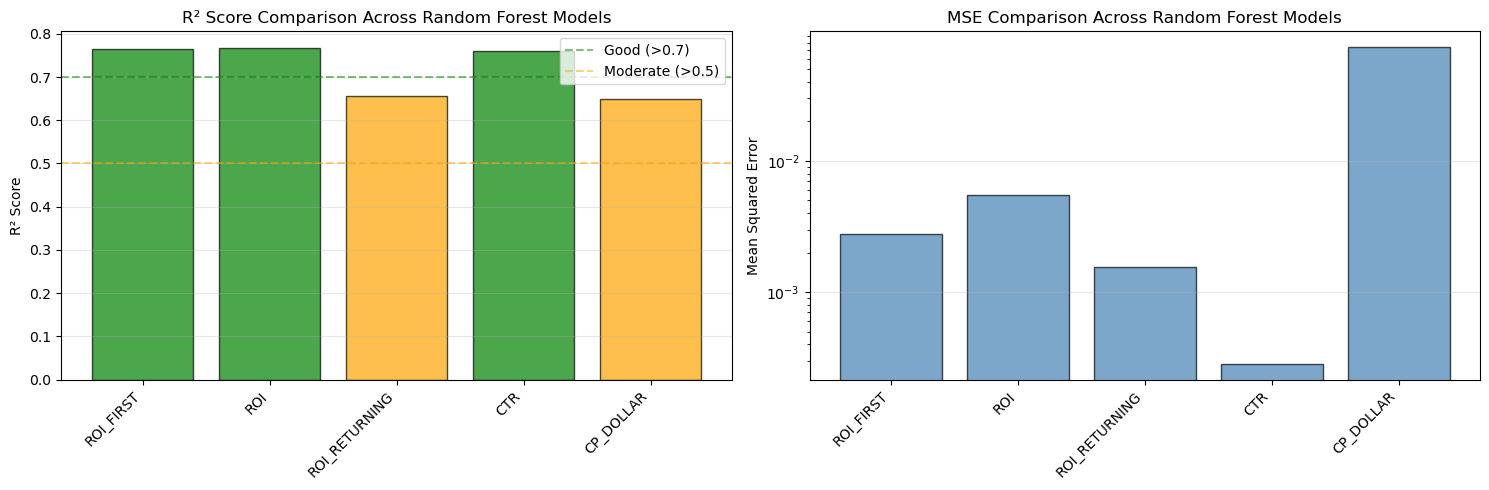

In [13]:
# Plot R² scores and MSE comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
r2_scores = [evaluation_results[t]['r2'] for t in target_variables]
colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red' for r2 in r2_scores]

axes[0].bar(range(len(target_variables)), r2_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(target_variables)))
axes[0].set_xticklabels(target_variables, rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison Across Random Forest Models')
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good (>0.7)')
axes[0].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.5)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MSE comparison (log scale for better visualization)
mse_scores = [evaluation_results[t]['mse'] for t in target_variables]
axes[1].bar(range(len(target_variables)), mse_scores, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(target_variables)))
axes[1].set_xticklabels(target_variables, rotation=45, ha='right')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE Comparison Across Random Forest Models')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


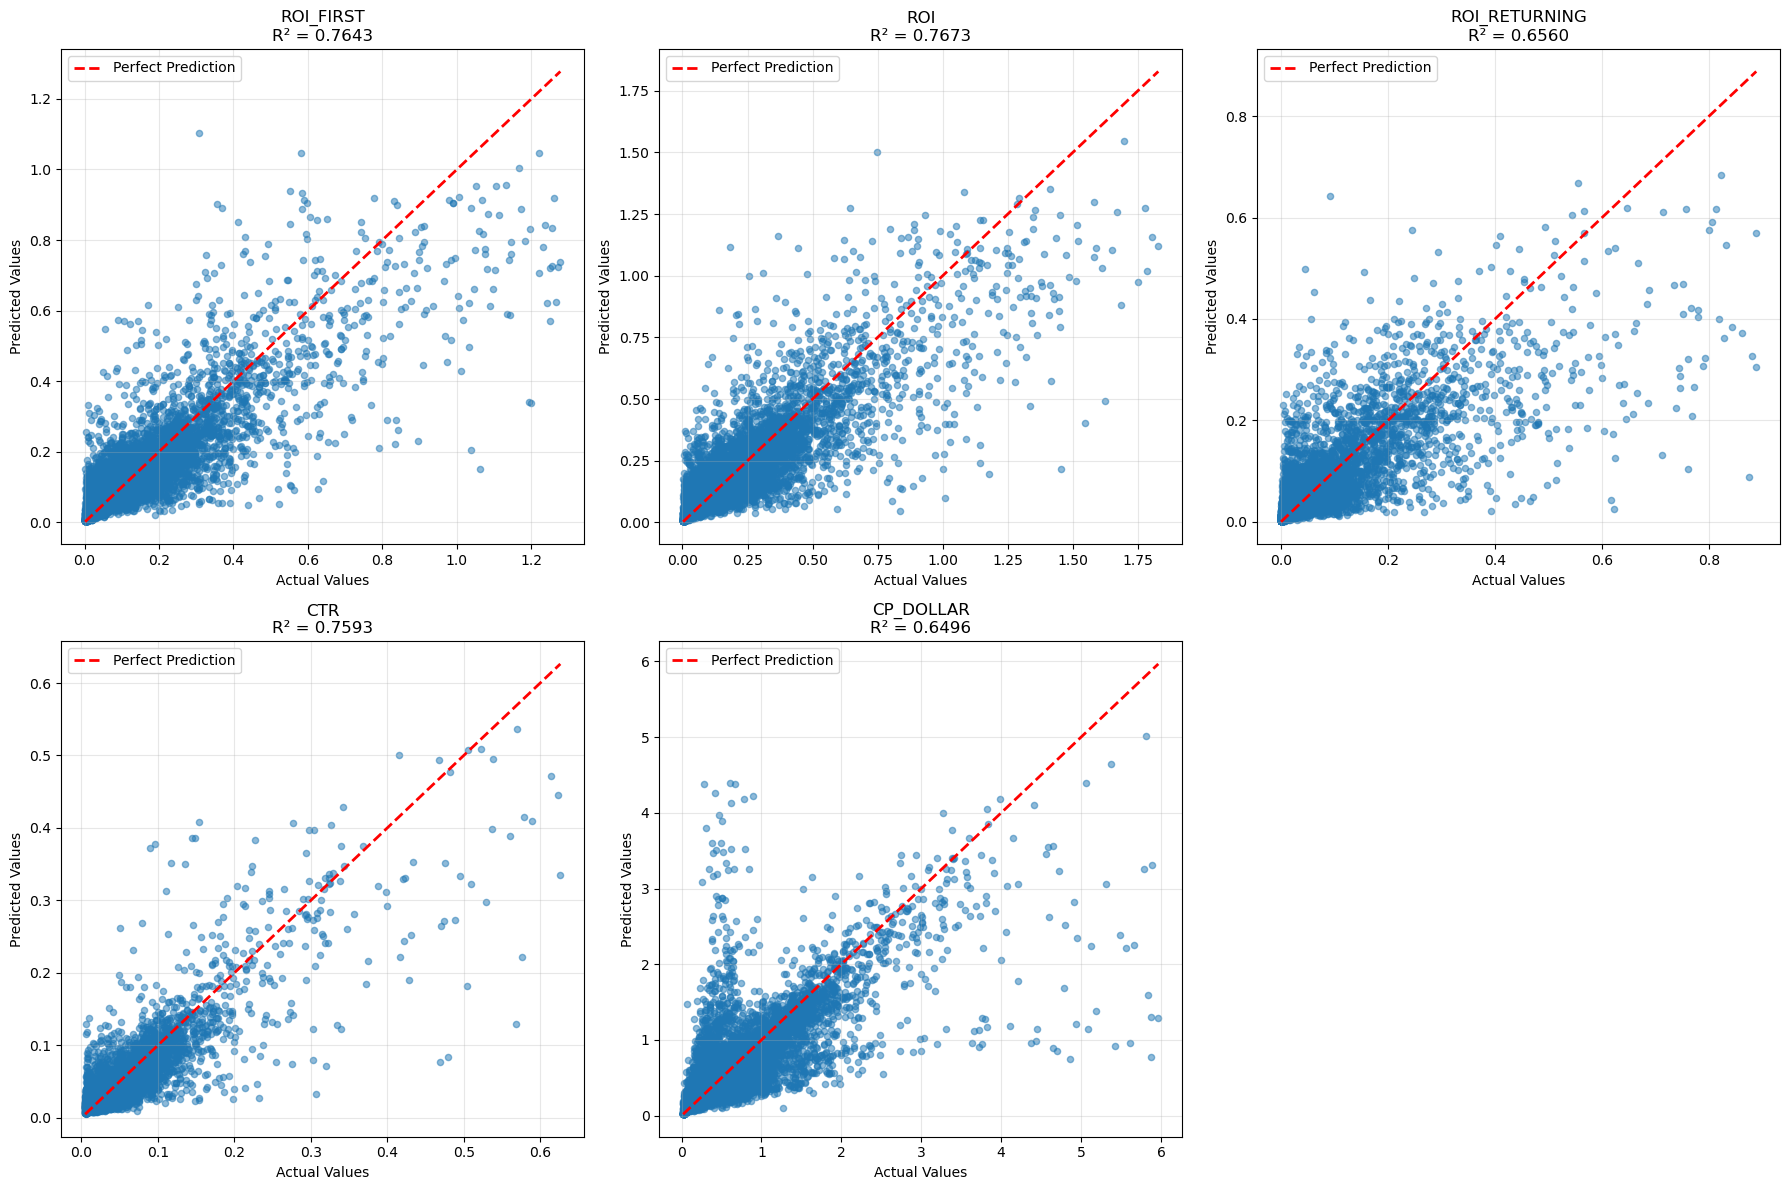

In [14]:
# Actual vs Predicted plots for each target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    r2 = evaluation_results[target]['r2']
    
    # Scatter plot
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'{target}\nR² = {r2:.4f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


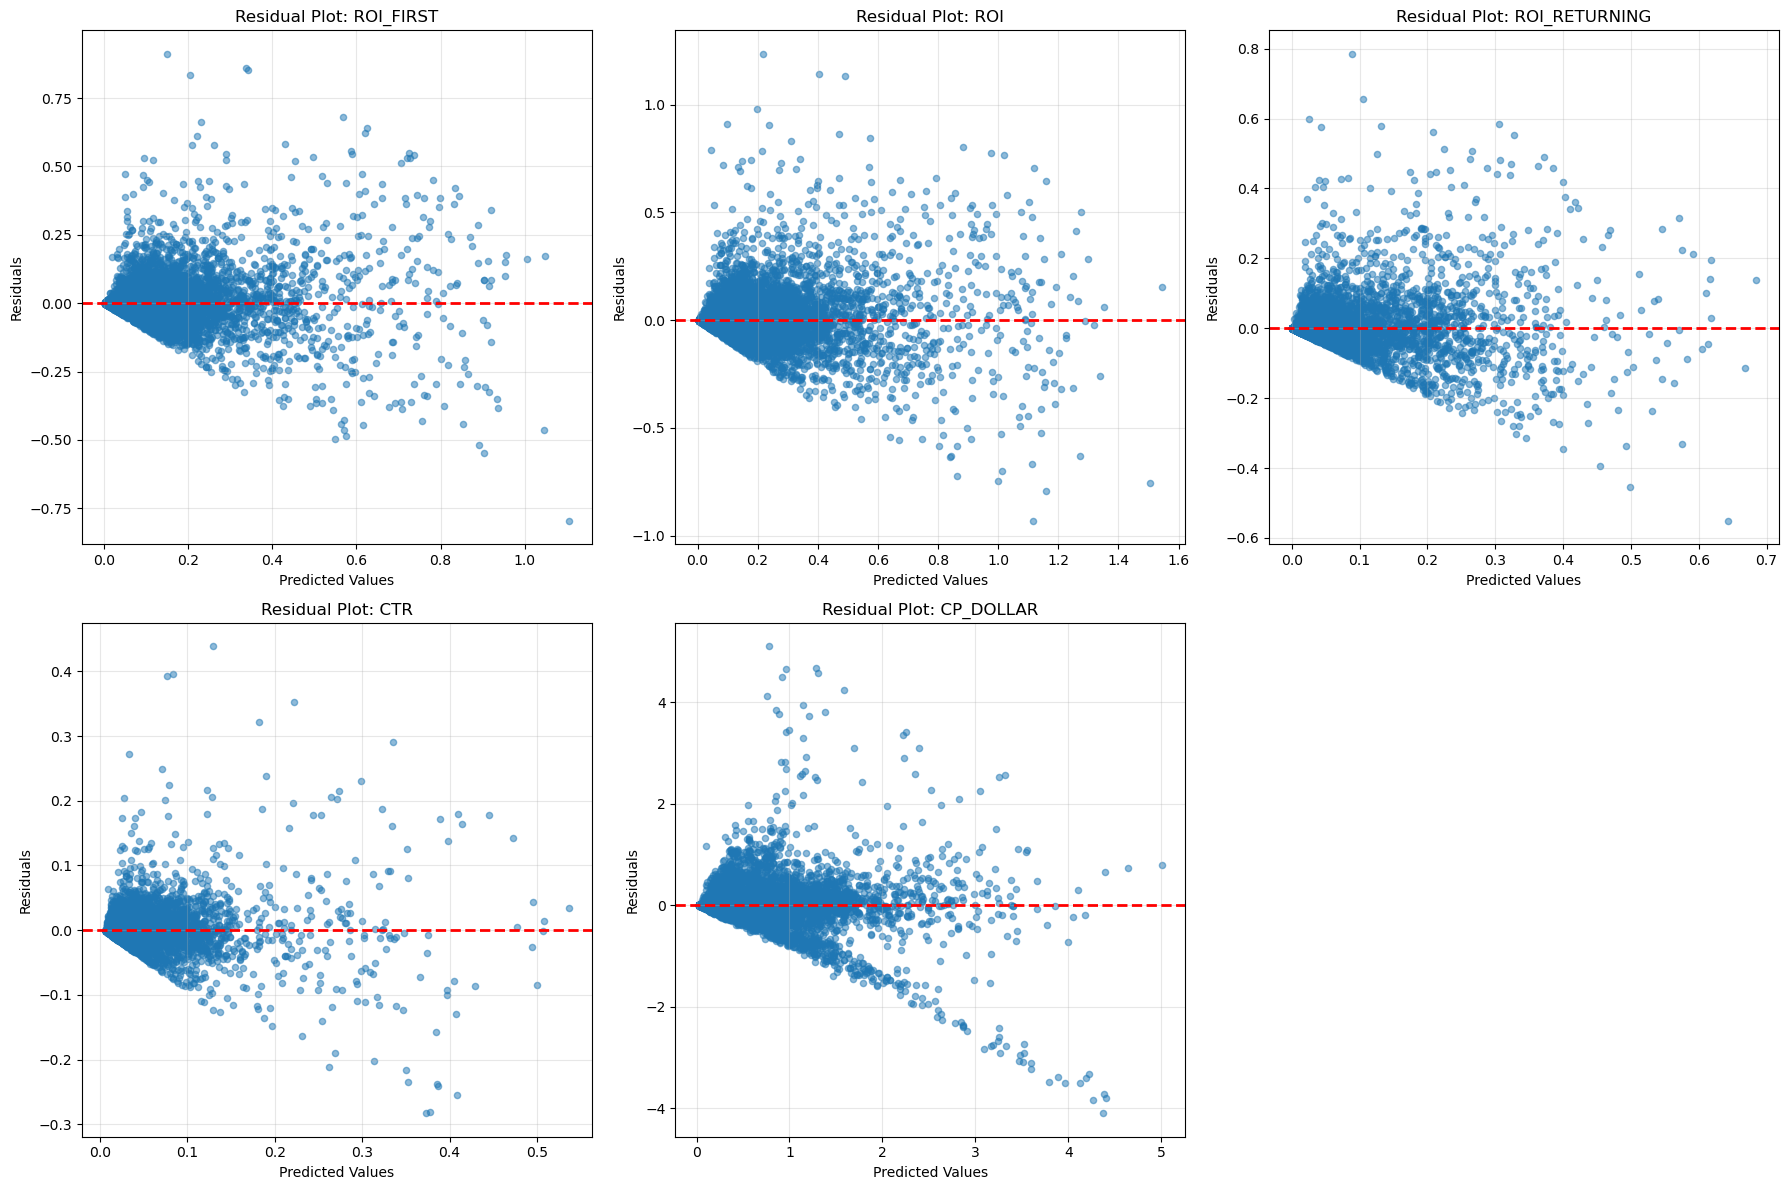

In [15]:
# Residual plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    residuals = y_true - y_pred
    
    # Residual plot
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'Residual Plot: {target}')
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


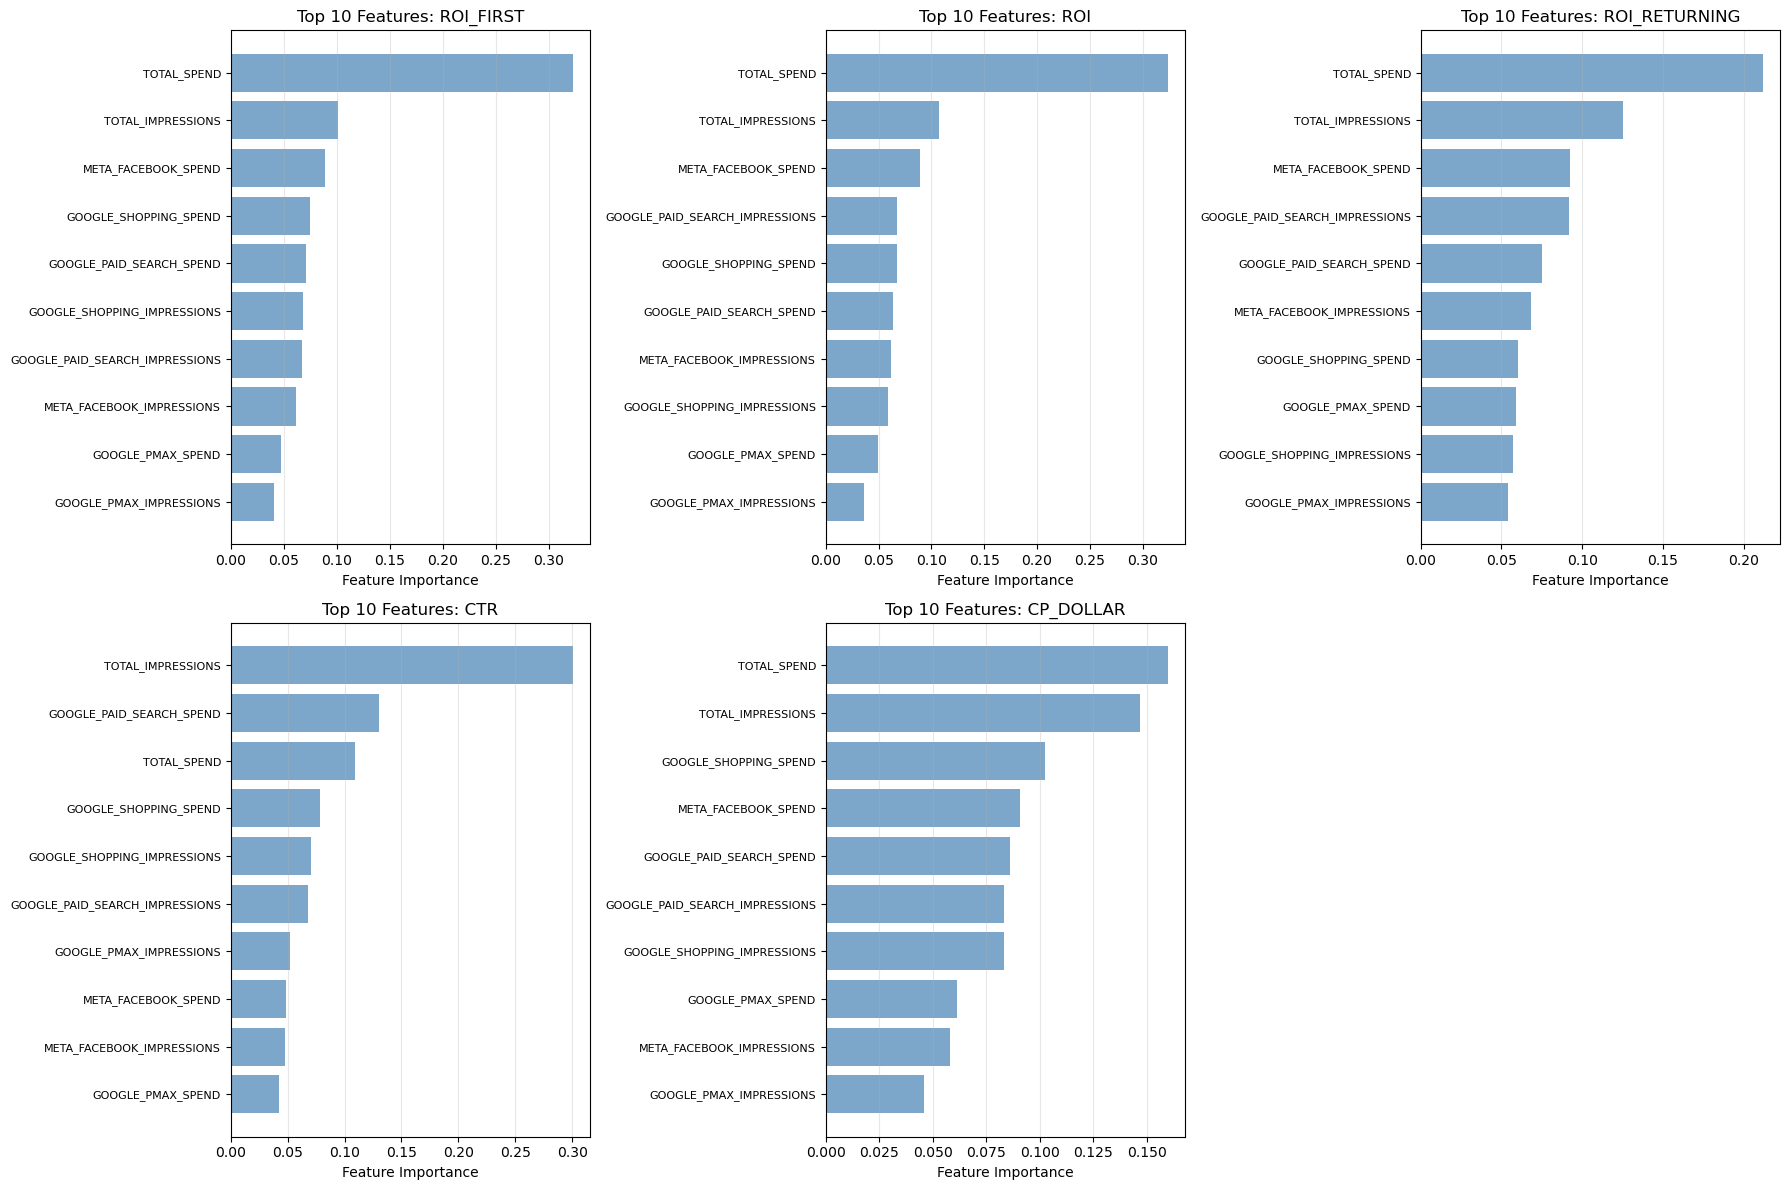

In [16]:
# Feature importance plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_names = X_train.columns

for idx, target in enumerate(target_variables):
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    
    axes[idx].barh(range(10), importances[indices], color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(10))
    axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
    axes[idx].set_xlabel('Feature Importance')
    axes[idx].set_title(f'Top 10 Features: {target}')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


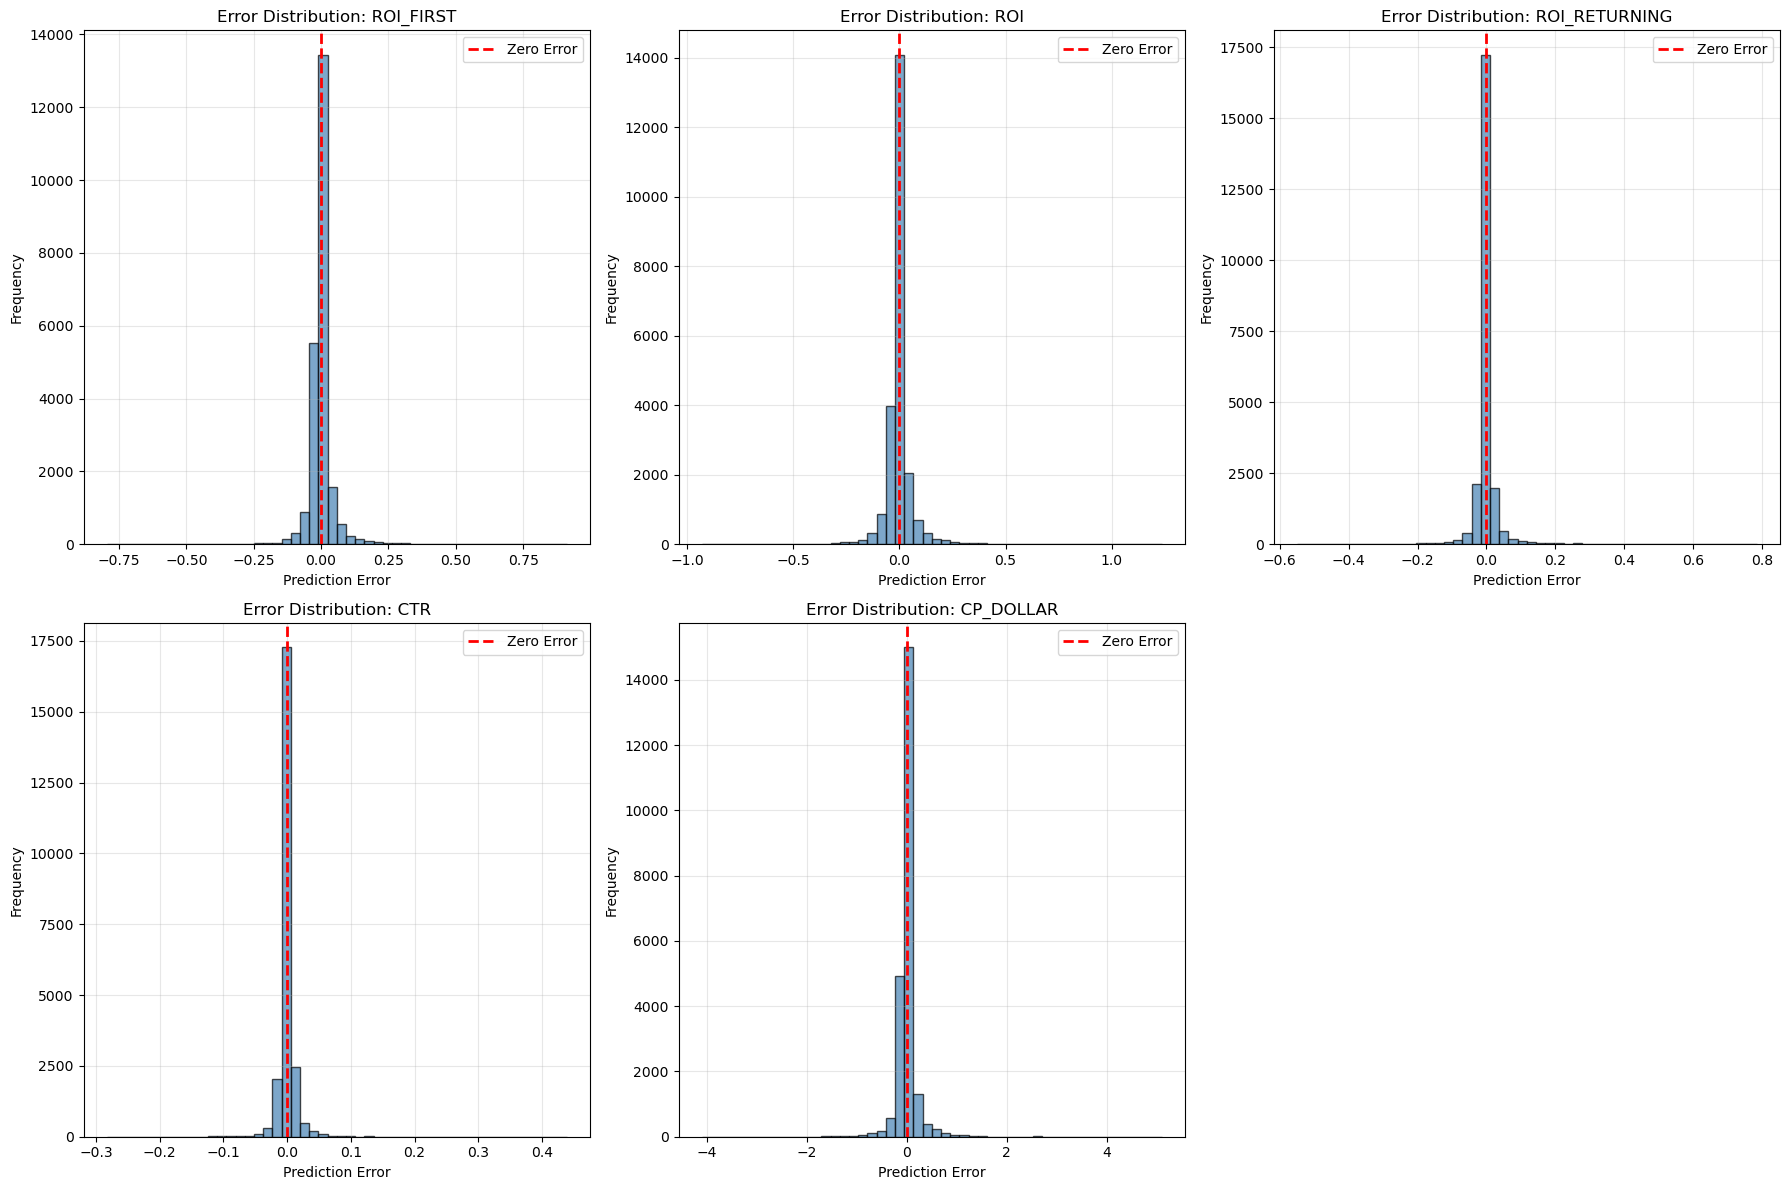

In [17]:
# Error distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    errors = y_true - y_pred
    
    # Histogram of errors
    axes[idx].hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
    axes[idx].set_xlabel('Prediction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Error Distribution: {target}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


In [18]:
for target in target_variables:
    print(f"\n{target}:")
    
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1]

    for i, idx in enumerate(indices[:10], 1):
        print(f"Rank: {i} Feature: {feature_names[idx]} Importance: {importances[idx]}")



ROI_FIRST:
Rank: 1 Feature: TOTAL_SPEND Importance: 0.32287558010330797
Rank: 2 Feature: TOTAL_IMPRESSIONS Importance: 0.10146580310227918
Rank: 3 Feature: META_FACEBOOK_SPEND Importance: 0.08929021066610382
Rank: 4 Feature: GOOGLE_SHOPPING_SPEND Importance: 0.07465535664208697
Rank: 5 Feature: GOOGLE_PAID_SEARCH_SPEND Importance: 0.07087024836499932
Rank: 6 Feature: GOOGLE_SHOPPING_IMPRESSIONS Importance: 0.06849343774643796
Rank: 7 Feature: GOOGLE_PAID_SEARCH_IMPRESSIONS Importance: 0.06737197242056953
Rank: 8 Feature: META_FACEBOOK_IMPRESSIONS Importance: 0.061204959584600885
Rank: 9 Feature: GOOGLE_PMAX_SPEND Importance: 0.04749328836546516
Rank: 10 Feature: GOOGLE_PMAX_IMPRESSIONS Importance: 0.04056963981188072

ROI:
Rank: 1 Feature: TOTAL_SPEND Importance: 0.32396702054794557
Rank: 2 Feature: TOTAL_IMPRESSIONS Importance: 0.1074047991519361
Rank: 3 Feature: META_FACEBOOK_SPEND Importance: 0.08943474794724932
Rank: 4 Feature: GOOGLE_PAID_SEARCH_IMPRESSIONS Importance: 0.06751627

In [19]:
# Create a comprehensive feature importance summary
insights = {}

for target in target_variables:
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Get top 5 features
    top_features = [(feature_names[i], importances[i]) for i in indices[:5]]
    insights[target] = top_features
    
    print(f"\n{target}:")
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"{i}. {feature} (Importance: {importance})")



ROI_FIRST:
1. TOTAL_SPEND (Importance: 0.32287558010330797)
2. TOTAL_IMPRESSIONS (Importance: 0.10146580310227918)
3. META_FACEBOOK_SPEND (Importance: 0.08929021066610382)
4. GOOGLE_SHOPPING_SPEND (Importance: 0.07465535664208697)
5. GOOGLE_PAID_SEARCH_SPEND (Importance: 0.07087024836499932)

ROI:
1. TOTAL_SPEND (Importance: 0.32396702054794557)
2. TOTAL_IMPRESSIONS (Importance: 0.1074047991519361)
3. META_FACEBOOK_SPEND (Importance: 0.08943474794724932)
4. GOOGLE_PAID_SEARCH_IMPRESSIONS (Importance: 0.06751627851299313)
5. GOOGLE_SHOPPING_SPEND (Importance: 0.06733460723928973)

ROI_RETURNING:
1. TOTAL_SPEND (Importance: 0.21195241675049997)
2. TOTAL_IMPRESSIONS (Importance: 0.1250791816843603)
3. META_FACEBOOK_SPEND (Importance: 0.09255503521279848)
4. GOOGLE_PAID_SEARCH_IMPRESSIONS (Importance: 0.09176464848205286)
5. GOOGLE_PAID_SEARCH_SPEND (Importance: 0.07534755375869606)

CTR:
1. TOTAL_IMPRESSIONS (Importance: 0.30054658568724063)
2. GOOGLE_PAID_SEARCH_SPEND (Importance: 0.130

In [20]:
# Calculate correlations for each target variable
correlation_results = {}

for target in target_variables:    
    # Calculate correlations between all features and target
    correlations = {}
    for feat in feature_names:
        corr = model_dataset[feat].corr(model_dataset[target])
        correlations[feat] = corr
    
    # Sort by absolute correlation value
    sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    correlation_results[target] = correlations
    
    # Display top features with positive and negative correlations
    print(f"\nTop Features with POSITIVE Correlation (increase {target}):")
    positive_features = [(f, c) for f, c in sorted_corrs if c > 0]
    for rank, (feat, corr) in enumerate(positive_features[:10], 1):
        if abs(corr) > 0.01:  # Only show meaningful correlations
            print(f"rank: {rank} feature: {feat} correlation: {corr} direction: ↑ Increases")
    
    print(f"\nTop Features with NEGATIVE Correlation (decrease {target}):")
    negative_features = [(f, c) for f, c in sorted_corrs if c < 0]
    for rank, (feat, corr) in enumerate(negative_features[:10], 1):
        if abs(corr) > 0.01:  # Only show meaningful correlations
            print(f"rank: {rank} feature: {feat} correlation: {corr} direction: ↓ Decreases")

print("\n" + "="*80)



Top Features with POSITIVE Correlation (increase ROI_FIRST):
rank: 1 feature: GOOGLE_SHOPPING_IMPRESSIONS correlation: 0.025642695046844858 direction: ↑ Increases

Top Features with NEGATIVE Correlation (decrease ROI_FIRST):
rank: 1 feature: TOTAL_SPEND correlation: -0.202595303097741 direction: ↓ Decreases
rank: 2 feature: META_FACEBOOK_SPEND correlation: -0.19318811258345517 direction: ↓ Decreases
rank: 3 feature: META_FACEBOOK_IMPRESSIONS correlation: -0.1698643968196311 direction: ↓ Decreases
rank: 4 feature: TOTAL_IMPRESSIONS correlation: -0.1277273123364869 direction: ↓ Decreases
rank: 5 feature: META_INSTAGRAM_SPEND correlation: -0.12448590606274175 direction: ↓ Decreases
rank: 6 feature: GOOGLE_PMAX_SPEND correlation: -0.11823578909876818 direction: ↓ Decreases
rank: 7 feature: META_INSTAGRAM_IMPRESSIONS correlation: -0.11039522651730778 direction: ↓ Decreases
rank: 8 feature: GOOGLE_PMAX_IMPRESSIONS correlation: -0.10859585116447074 direction: ↓ Decreases
rank: 9 feature: GOO

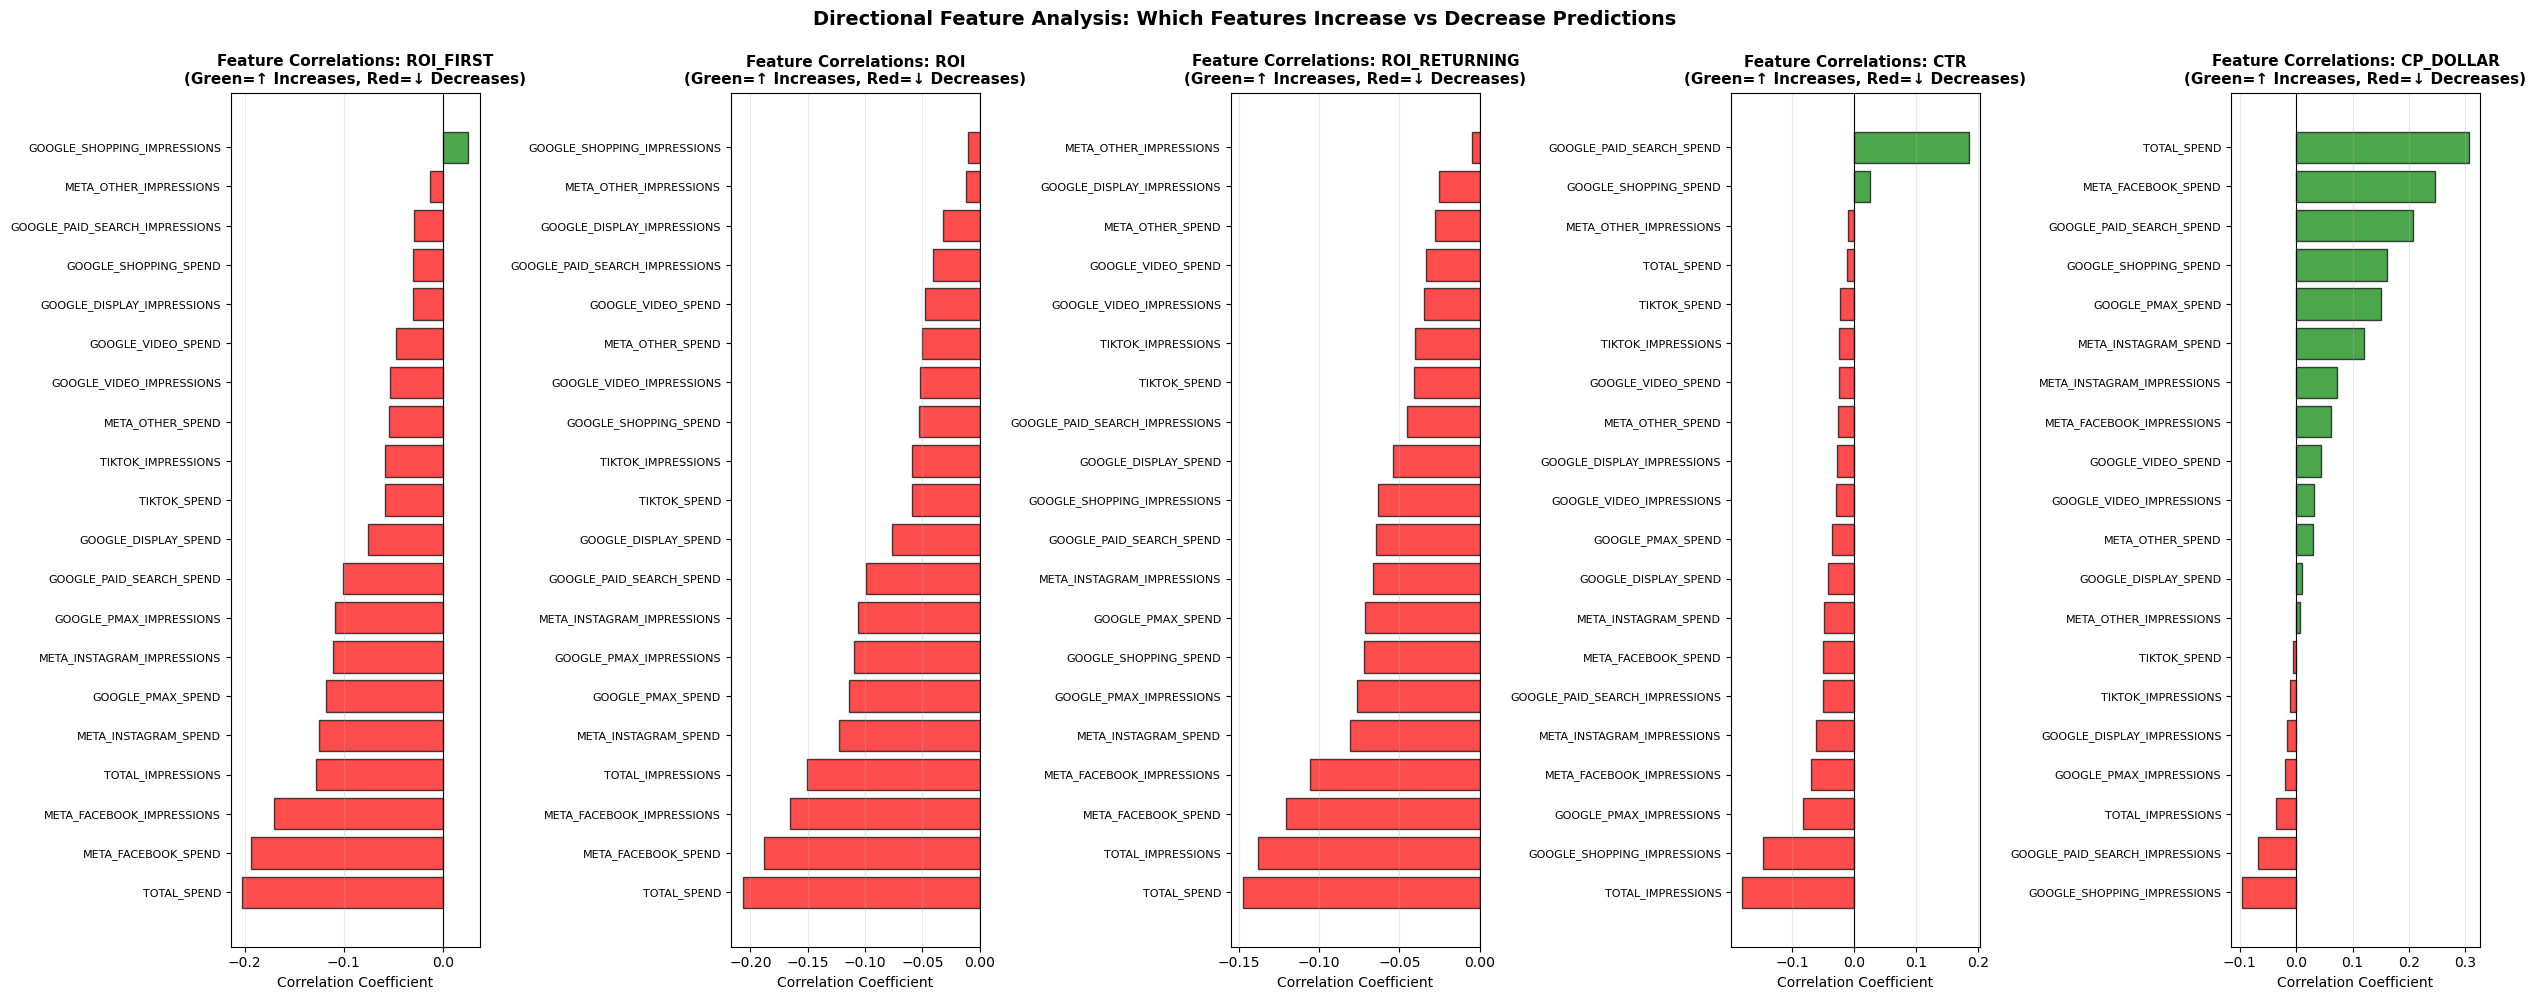

In [21]:
# Visualize correlations as heatmap
fig, axes = plt.subplots(1, len(target_variables), figsize=(5*len(target_variables), 10))
if len(target_variables) == 1:
    axes = [axes]

for idx, target in enumerate(target_variables):
    # Get correlations for this target
    corrs = correlation_results[target]
    
    # Create DataFrame for heatmap
    corr_df = pd.DataFrame({
        'Feature': list(corrs.keys()),
        'Correlation': list(corrs.values())
    })
    corr_df = corr_df.sort_values('Correlation', ascending=False)
    
    # Create bar plot
    colors = ['green' if c > 0 else 'red' for c in corr_df['Correlation']]
    axes[idx].barh(range(len(corr_df)), corr_df['Correlation'], color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_yticks(range(len(corr_df)))
    axes[idx].set_yticklabels(corr_df['Feature'], fontsize=8)
    axes[idx].set_xlabel('Correlation Coefficient', fontsize=10)
    axes[idx].set_title(f'Feature Correlations: {target}\n(Green=↑ Increases, Red=↓ Decreases)', 
                       fontsize=11, fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

plt.suptitle('Directional Feature Analysis: Which Features Increase vs Decrease Predictions', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


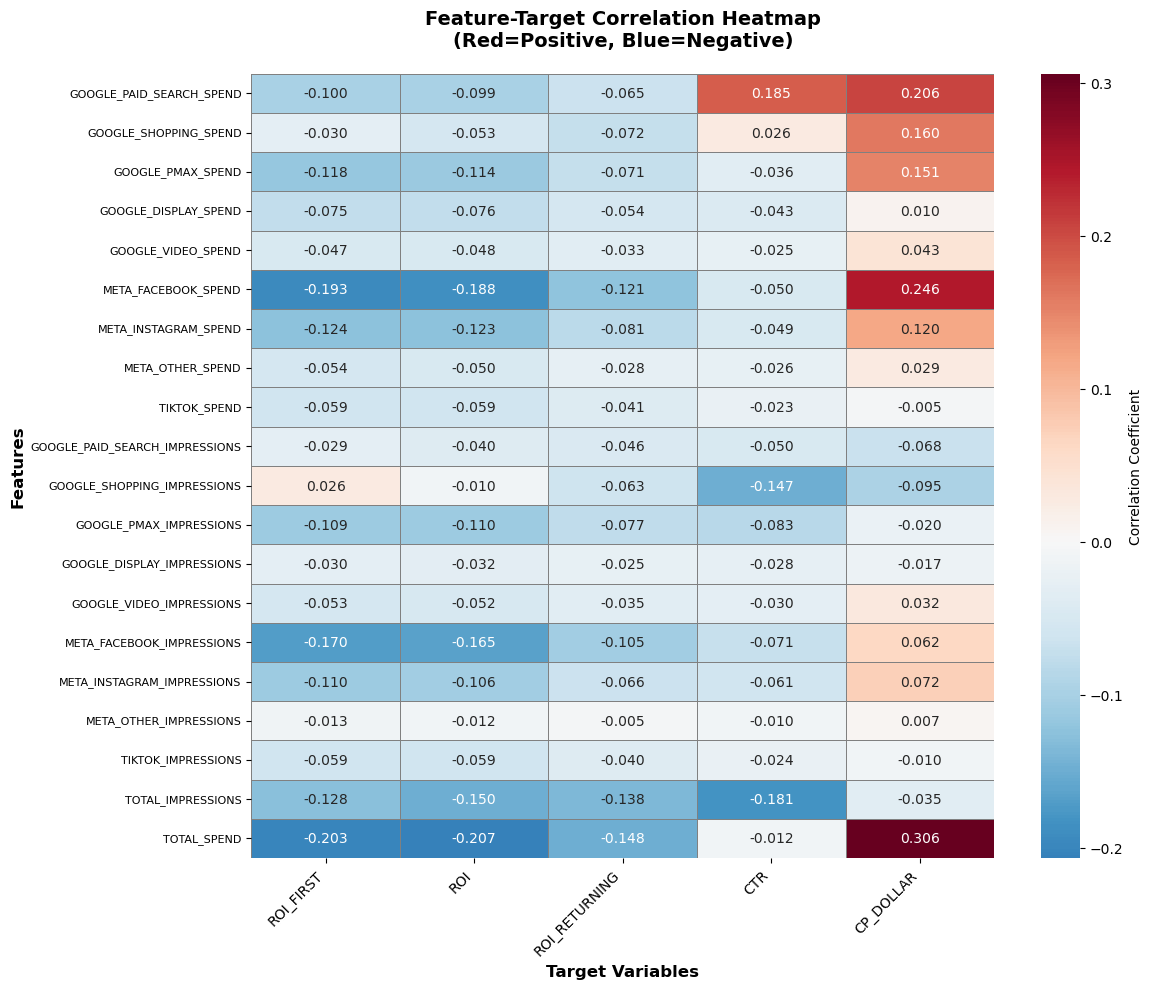

In [22]:
# Create comprehensive correlation heatmap across all targets
corr_matrix = pd.DataFrame({
    target: [correlation_results[target][feat] for feat in feature_names]
    for target in target_variables
}, index=feature_names)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation Coefficient'}, 
            xticklabels=target_variables, yticklabels=feature_names,
            linewidths=0.5, linecolor='gray')
plt.title('Feature-Target Correlation Heatmap\n(Red=Positive, Blue=Negative)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Target Variables', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()



Top 5 features for ROI_FIRST:
  1. TOTAL_SPEND (importance: 0.32287558010330797)
  2. TOTAL_IMPRESSIONS (importance: 0.10146580310227918)
  3. META_FACEBOOK_SPEND (importance: 0.08929021066610382)
  4. GOOGLE_SHOPPING_SPEND (importance: 0.07465535664208697)
  5. GOOGLE_PAID_SEARCH_SPEND (importance: 0.07087024836499932)


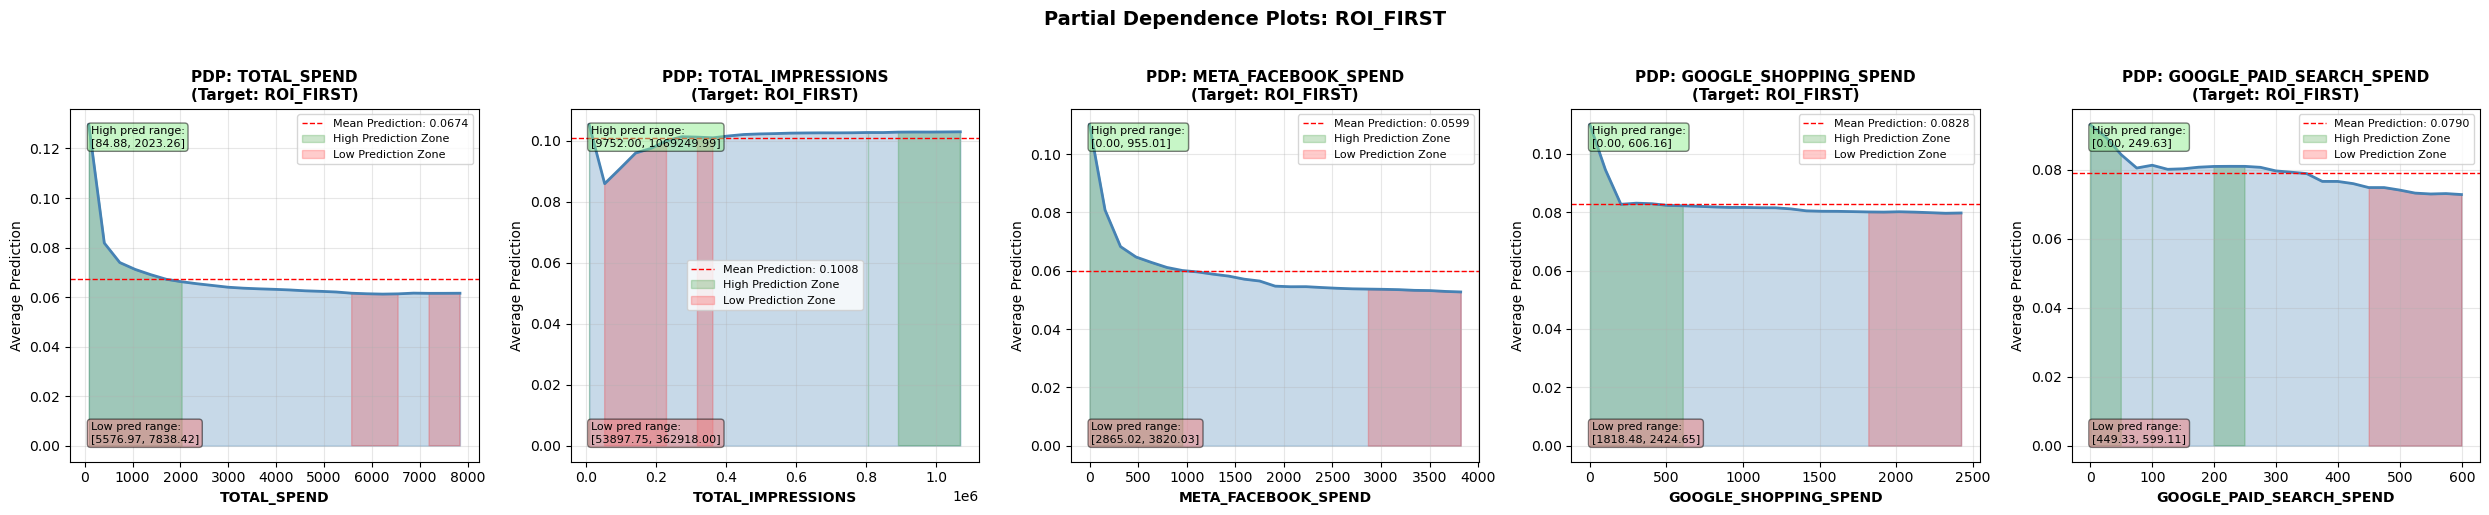


Top 5 features for ROI:
  1. TOTAL_SPEND (importance: 0.32396702054794557)
  2. TOTAL_IMPRESSIONS (importance: 0.1074047991519361)
  3. META_FACEBOOK_SPEND (importance: 0.08943474794724932)
  4. GOOGLE_PAID_SEARCH_IMPRESSIONS (importance: 0.06751627851299313)
  5. GOOGLE_SHOPPING_SPEND (importance: 0.06733460723928973)


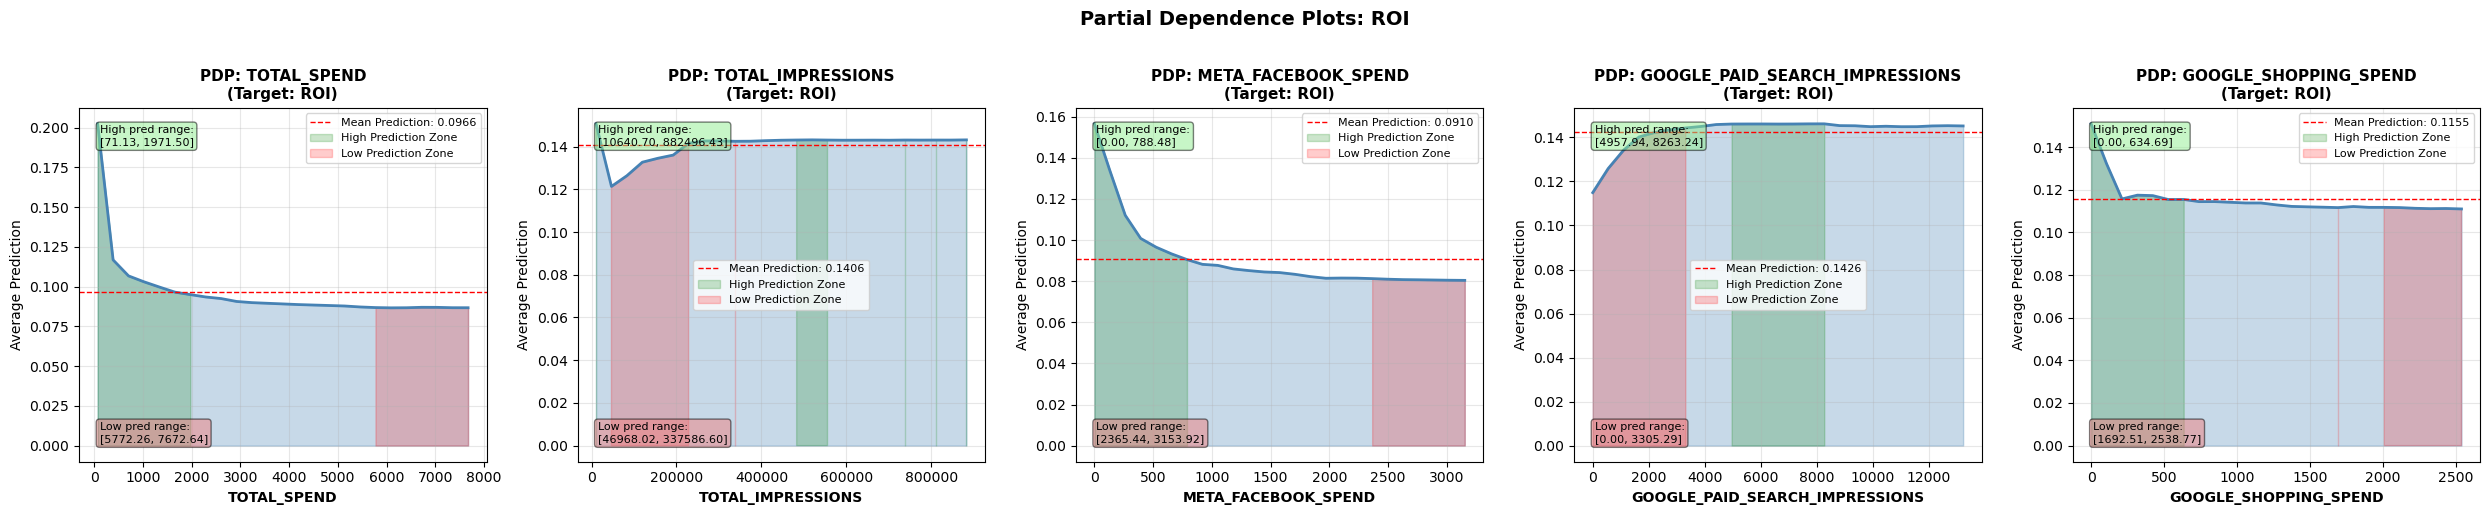


Top 5 features for ROI_RETURNING:
  1. TOTAL_SPEND (importance: 0.21195241675049997)
  2. TOTAL_IMPRESSIONS (importance: 0.1250791816843603)
  3. META_FACEBOOK_SPEND (importance: 0.09255503521279848)
  4. GOOGLE_PAID_SEARCH_IMPRESSIONS (importance: 0.09176464848205286)
  5. GOOGLE_PAID_SEARCH_SPEND (importance: 0.07534755375869606)


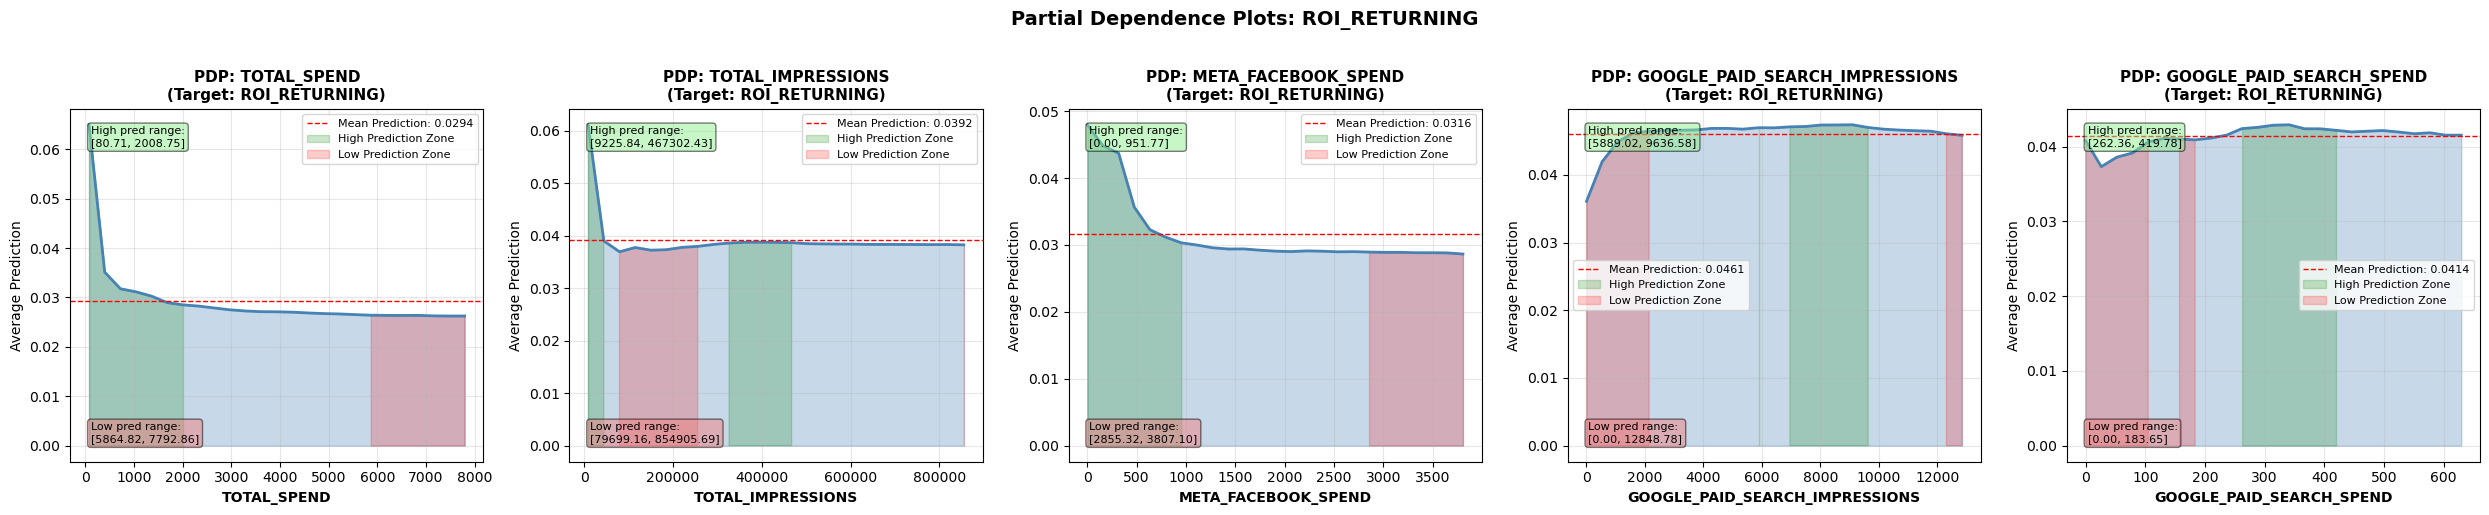


Top 5 features for CTR:
  1. TOTAL_IMPRESSIONS (importance: 0.30054658568724063)
  2. GOOGLE_PAID_SEARCH_SPEND (importance: 0.1301090833808921)
  3. TOTAL_SPEND (importance: 0.10957890170335778)
  4. GOOGLE_SHOPPING_SPEND (importance: 0.07812426339308015)
  5. GOOGLE_SHOPPING_IMPRESSIONS (importance: 0.07069396001636814)


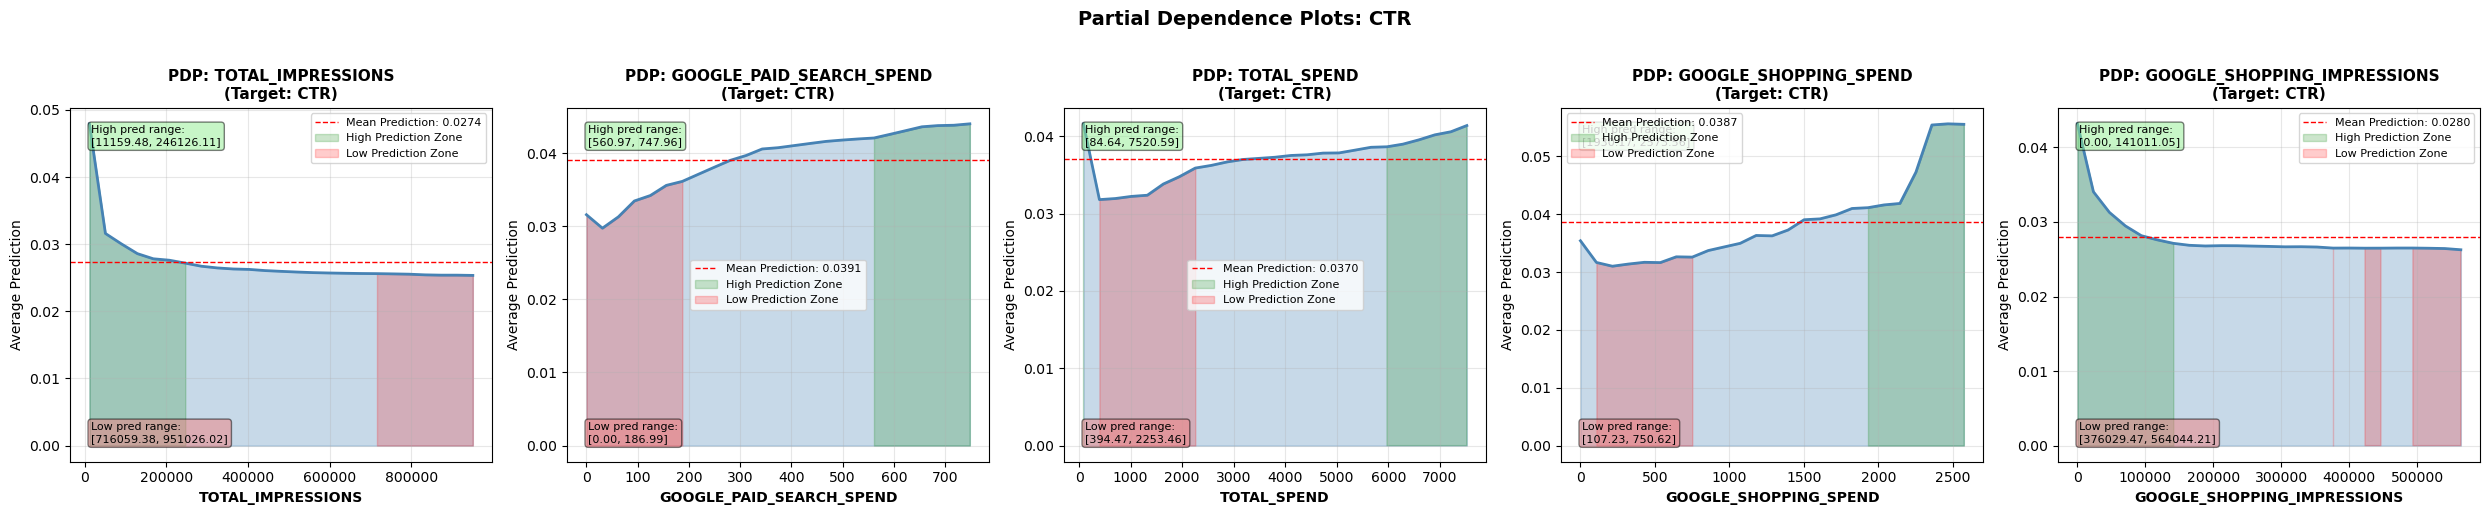


Top 5 features for CP_DOLLAR:
  1. TOTAL_SPEND (importance: 0.1598409029744593)
  2. TOTAL_IMPRESSIONS (importance: 0.14668136507307525)
  3. GOOGLE_SHOPPING_SPEND (importance: 0.10247612030889625)
  4. META_FACEBOOK_SPEND (importance: 0.09092686622209574)
  5. GOOGLE_PAID_SEARCH_SPEND (importance: 0.08598012492062297)


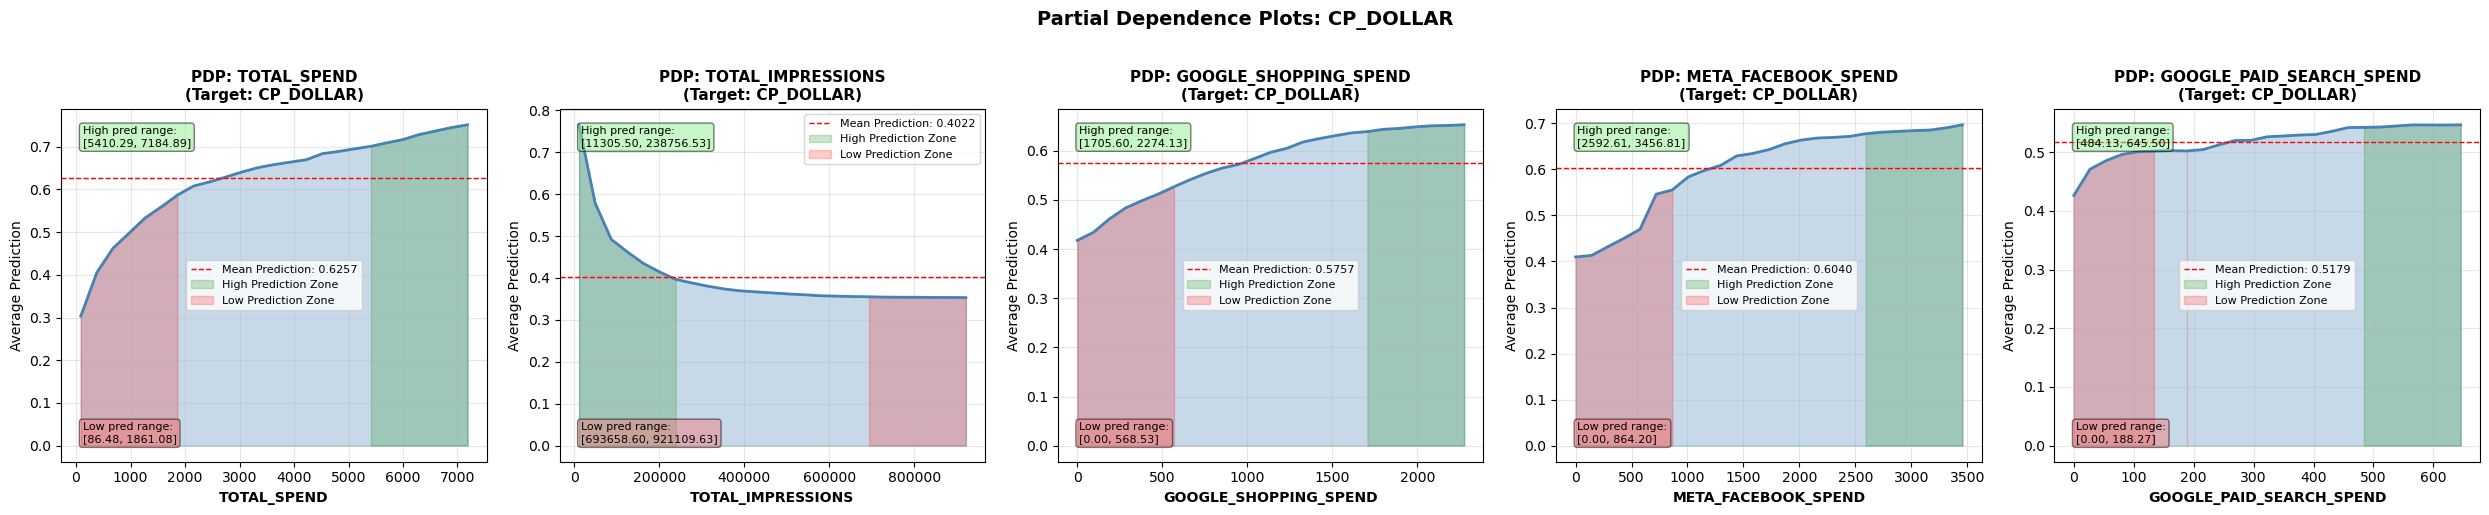

In [23]:
# Number of top features to analyze per target
n_top_features = 5

# Create PDP plots for each target variable
for target_idx, target in enumerate(target_variables):
    
    # Get top features for this target
    importances = models[target].feature_importances_
    feature_indices = np.argsort(importances)[::-1][:n_top_features]
    top_features = [feature_names[i] for i in feature_indices]
    
    print(f"\nTop {n_top_features} features for {target}:")
    for i, feat in enumerate(top_features, 1):
        print(f"  {i}. {feat} (importance: {importances[feature_indices[i-1]]})")
    
    # Create PDP plots
    try:
        # Use a sample of training data for faster computation
        sample_size = min(1500, len(X_train))
        sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_sample = X_train.iloc[sample_indices]
        
        # Store results for each feature
        pdp_results_list = []
        for feat_idx, feat_name in enumerate(top_features):
            feat_pdp = partial_dependence(
                models[target],
                X_sample,
                features=[feat_name],
                grid_resolution=25,
                kind='average'
            )
            pdp_results_list.append(feat_pdp)
        
        # Create visualization
        fig, axes = plt.subplots(1, len(top_features), figsize=(5*len(top_features), 5))
        if len(top_features) == 1:
            axes = [axes]
        
        for idx, feat_name in enumerate(top_features):
            ax = axes[idx]
            
            # Get feature values and average predictions from individual PDP result
            # When computing for a single feature, results are in [0] index
            feature_values = pdp_results_list[idx]['grid_values'][0]
            avg_predictions = pdp_results_list[idx]['average'][0]
            
            # Ensure 1D arrays
            feature_values = np.array(feature_values).flatten()
            avg_predictions = np.array(avg_predictions).flatten()
            
            # Plot PDP
            ax.plot(feature_values, avg_predictions, linewidth=2, color='steelblue')
            ax.fill_between(feature_values, avg_predictions, alpha=0.3, color='steelblue')
            
            # Add horizontal line at mean prediction
            mean_pred = np.mean(avg_predictions)
            ax.axhline(y=mean_pred, color='red', linestyle='--', linewidth=1, 
                      label=f'Mean Prediction: {mean_pred:.4f}')
            
            # Identify high and low prediction zones
            high_threshold = np.percentile(avg_predictions, 75)
            low_threshold = np.percentile(avg_predictions, 25)
            
            # Highlight high prediction zones
            high_mask = avg_predictions >= high_threshold
            if np.any(high_mask):
                ax.fill_between(feature_values, avg_predictions, 
                               where=high_mask, alpha=0.2, color='green', 
                               label='High Prediction Zone')
            
            # Highlight low prediction zones
            low_mask = avg_predictions <= low_threshold
            if np.any(low_mask):
                ax.fill_between(feature_values, avg_predictions, 
                               where=low_mask, alpha=0.2, color='red', 
                               label='Low Prediction Zone')
            
            ax.set_xlabel(f'{feat_name}', fontsize=10, fontweight='bold')
            ax.set_ylabel('Average Prediction', fontsize=10)
            ax.set_title(f'PDP: {feat_name}\n(Target: {target})', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            # Add value range annotations
            high_values = feature_values[high_mask]
            low_values = feature_values[low_mask]
            if len(high_values) > 0:
                ax.text(0.05, 0.95, f'High pred range:\n[{high_values.min():.2f}, {high_values.max():.2f}]',
                       transform=ax.transAxes, fontsize=8, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
            if len(low_values) > 0:
                ax.text(0.05, 0.05, f'Low pred range:\n[{low_values.min():.2f}, {low_values.max():.2f}]',
                       transform=ax.transAxes, fontsize=8, verticalalignment='bottom',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        
        plt.suptitle(f'Partial Dependence Plots: {target}', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    except Exception:
        continue


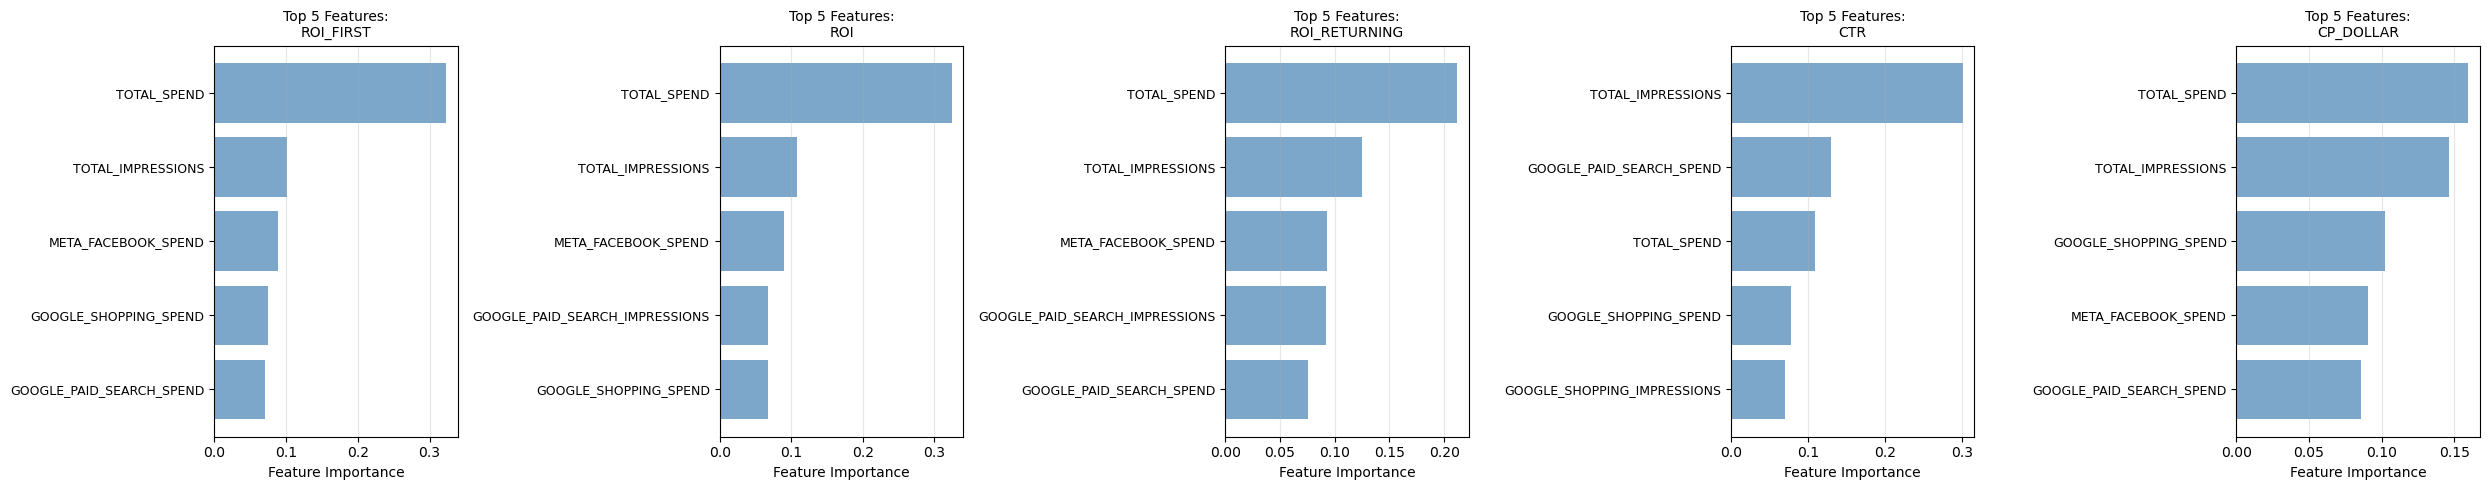

In [24]:
# Visualize top features for each metric side by side
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, target in enumerate(target_variables):
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1][:5]  # Top 5 features
    
    axes[idx].barh(range(5), importances[indices], color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(5))
    axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=9)
    axes[idx].set_xlabel('Feature Importance')
    axes[idx].set_title(f'Top 5 Features:\n{target}', fontsize=10)
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
